#  pRF analysis on visual cortex (partial volume), on Gray Matter (not layered)

In [38]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Fitter, Extend_Iso2DGaussianFitter
from prfpy.rf import gauss2D_iso_cart
import os
import yaml
import scipy.io
from marcus_prf_eg.utils import *
from marcus_prf_eg.plot_functions import * #Graph tools provided by Marcus Daghlian (https://github.com/mdaghlian)

#Adapted from initial pRF fitting tutorial provided by Marcus Daghlian (https://github.com/mdaghlian)

In [39]:
MAIN_PATH=os.getenv("DERIVATIVES")

#USER INPUT:
subject='sub-05'
depth='GM' #Gray matter (GM) or layer's depth (e.g. 0.0 for white matter surface, 1.0 for pial surface) 
space='fsnative'
project='EGRET-AAA'
denoising='pybest'
atlas = 'benson' # manual delineation ('manual') or benson atlas ('benson')
dm_filename='design_task-ret.mat' #should be placed in the 'derivatives/pRFM'folder; same dm for all subjects'
prf_settings_filename='fit_settings_prf_pilot1.yml' #should be placed in the 'derivatives/pRFM'folder; same prf settings for all subjects'

if atlas=='benson':
    rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2','V3a', 'V3b']
elif atlas =='manual':
    rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2']

## Load design matrix

(100, 100, 210)

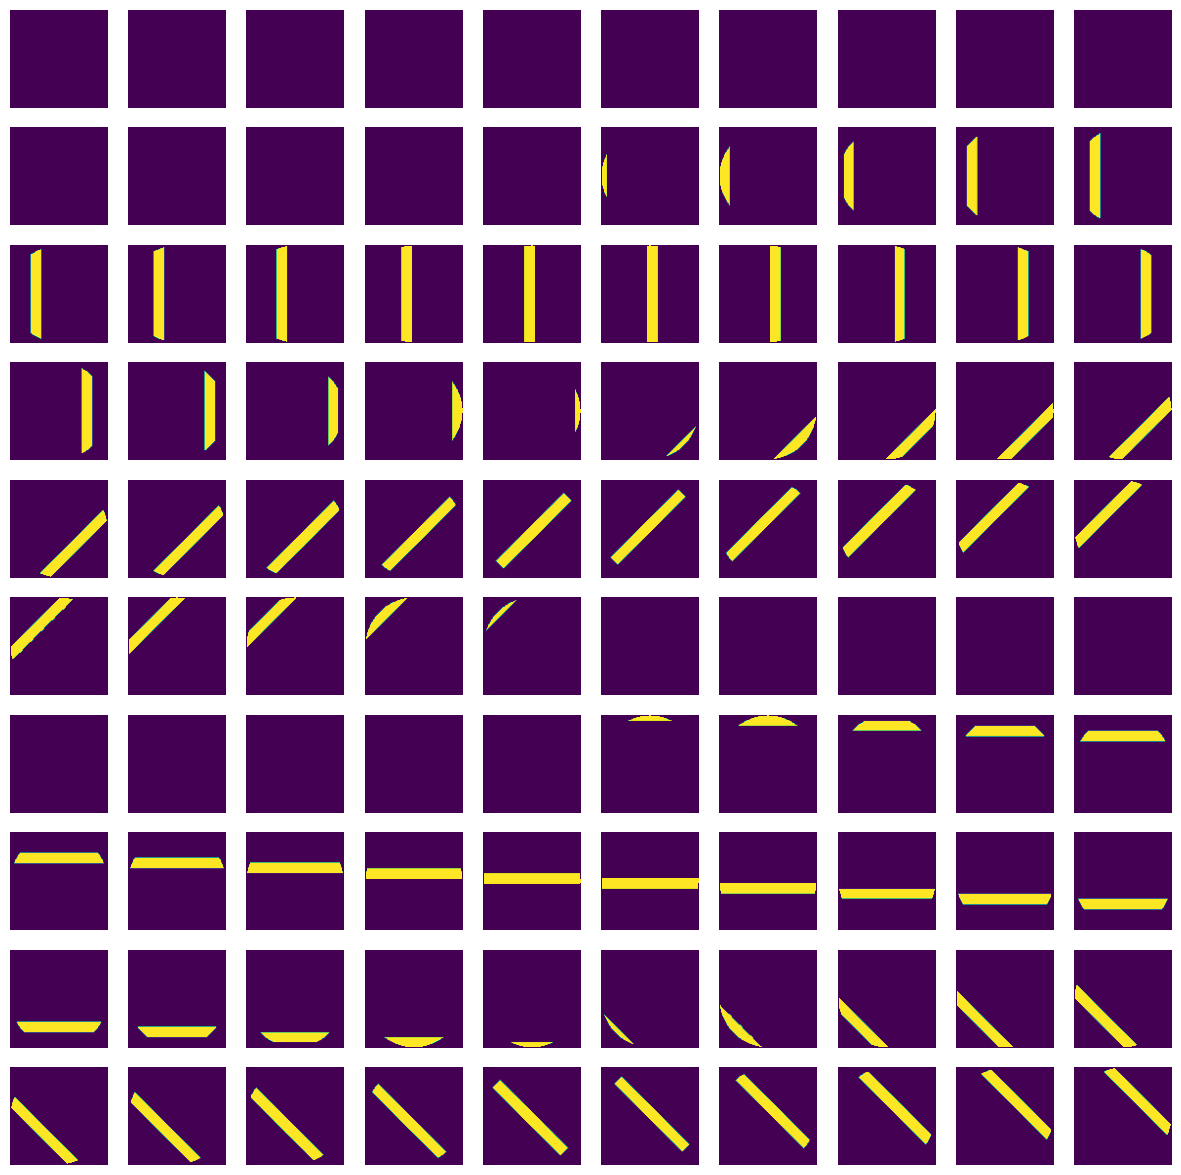

In [40]:
dm =scipy.io.loadmat(f'{MAIN_PATH}/pRFM/{dm_filename}')['stim'] #same design matrix for all subjects
# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(15,15)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')

dm=dm[:,:,5:215]
dm.shape

When setting up the model it is important to be clear what settings you are using, and make it easily reproducible. To that end it is recommended that you keep all the specific values in a .yml file, which can be loaded in (rather than hard coding "magic" numbers in your script)

In [41]:
# Load the settings from .yml file
prf_settings_file = f'{MAIN_PATH}/pRFM/{fit_settings_prf_pilot1}' #same prf settings for all subjects
with open(prf_settings_file) as f:
    prf_settings = yaml.safe_load(f)

# Creating stimulus object
Before fitting the PRFs we need to create the design matrix, i.e., a binary representation of the stimulus. The stimuli used in this example is a bar moving across the visual field (see eg_screen_shot.png for an example).

prfpy needs the design matrix to be a numpy array of n x n x time points. Each time point will correspond to the timepoints in the fMRI sequence. n is the number of pixels in the design matrix.

Going from the stimulus shown in the scanner to the n x n x timepoints in the design matrix involves 3 steps:

[1] Binarize the stimulus (where there is stimulus=1, no stimulus=0)

[2] Make it square (i.e., cut off the unstimulated part of the screen). This is because typically the stimuli are presented in a circular aperture; therefore including the full rectangle of the screen is unnecessary.

[3] Downsample the stimulus (so that it can run faster, e.g., from 1080 x 1080 to 100 x 100)

If you want you could also just recreate the design matrix from same parameters you used to make the stimulus (i.e., defining bar/wedge position over time). This doesn't matter

In [42]:
# Now we need to enter the design matrix in a way that prfpy can read it. 
# We do this using the PRFStimulus2D object
# Information we need
# -> Screen size (height), and distance (to the eye)
# This is so that we can convert into degrees of visual angle (dov)
# -> TR: This is so that we know the time (in s), of each 'frame' / pt in the time series
# E.g( If we have 225 time points. The total length of scan is TR * 225 (1.5*225) 
prf_stim = PRFStimulus2D(
    screen_size_cm=prf_settings['screen_size_cm'],          # height of the screen (i.e., the diameter of the stimulated region)
    screen_distance_cm=prf_settings['screen_distance_cm'],  # Distance of screen to eye
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=prf_settings['TR'],                                  # TR
    )
print(f'Screen size in degrees of visual angle = {prf_stim.screen_size_degrees}')

# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...


Screen size in degrees of visual angle = 11.450128652841203


# Preparing the data
The next step is to prepare the fMRI time series. The format that prfpy wants is a numpy array of number of 
For prfpy the time series needs to be 2D numpy array, where the first dimension is units (i.e., voxels or vertices) and the second dimension is time. The number of timepoints in your data should match the number in the design matrix (here it is 225). 

A couple of notes:

[*] Preprocessing? I assume that all of the important stuff, i.e., denoising, removing confounds has been done already. This is just to prepare the data for prfpy specifically. 

[*] Averaging? The more runs (i.e., repetitions of the same stimulus) you average over, the less noise, and the better the prf estimates will be. You can fit on a single run (especially in high SNR situations, e.g., using 7T) without averaging, but quality will be less good. 

[*] Voxels or vertices? In principle you can fit any time series data with a prf model. I always fit using vertices, with the data sampled to the cortical surface. This will make visualisations much easier, if you want to plot your PRF parameters on the cortical surface. You can then use tools like pycortex

[*] Percent signal change? Again, in principle you can fit any time series data with a prf model. I use percent signal change, with the baseline set to 0. Why do this? It makes it easier to compare timeseries across voxels when the units are the same (as opposed to the arbitrary values you get out of "raw" fMRI data). Also, if you do *not* set the baseline value to 0 (i.e. the amplitude of the prf model when there is 0 stimulation) you need to fit it for each vertex. There are also added complications when you have PRFs with inhibitory components. Another option is to use z-scoring rather than psc.

[*] Include first part of timeseries? Some people will remove the first (e.g.,5) timepoints of the fMRI data. This is because perhaps it takes a couple of seconds for the subject to get used to the scanner / stimulus or maybe there are startup effects... If you want to do this, make sure you make the corresponding changes to the design matrix.  

### Steps, using example data
I have provided some example time series data for 100 vertices

[1] Convert to percent signal change

[2] Set the median value during the baseline condition (i.e., when there is no stimulation) to zero

See functions in marcus_prf_eg/utils for more details


Example, raw time series. You can already see the peaks corresponding to the bar passes. 
But the units are arbitrary... We want to change it to be in psc
Also we can improve the SNR by averaging over the 2 runs...

In [43]:
# # Do the averaging and baselining...
# # During the first 20 time points, there is NO stimulation. So we use this to set the baseline
# psc_avg_ts = raw_ts_to_average_psc(
#     raw_ts=[run1, run2],        # Enter the runs as a list of np.ndarrays
#     baseline=19,                # The first 20 time points, there is NO stimulation. So we use this to set the baseline
# )
#
# print('''Now we can see what the the time series looks like after psc, baselining and averaging:''')
# psc_avg_ts=np.load('/Users/mayra/PycharmProjects/Github/marcus_prfpy_tutorial/pilot1/ses-1/sub-001_ses-1_task-ret_hemi-LR_desc-avg_bold.npy').T[:,:]
psc_avg_ts_full=np.load(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/{subject}_ses-1_task-ret_hemi-LR_desc-avg_bold_{depth}.npy').T[:,:]
print(psc_avg_ts_full.shape)

if psc_avg_ts_full.shape[1]>225:
    psc_avg_ts_full=psc_avg_ts_full[:,:225]

psc_avg_ts_full.shape

(281741, 210)


(281741, 210)

In [44]:
import cortex
import cortex.polyutils
#select voxels in selected ROIs



if subject=='fsaverage':
    fs_dirPATH='/Volumes/May_fMRI/Inzicht_CFM/derivatives/freesurfer'
else:
    fs_dirPATH=f'{MAIN_PATH}/freesurfer'

# %%
# In order to get the number of vertices in this subject's cortical surface
# we have to load in their surfaces and get the number of points in each
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]

## Mask voxels outside visual cortex based on Benson Atlas for efficiency

In [45]:
# First we need to import the surfaces for this subject
numel_left = surfs[0].pts.shape[0]
numel_right = surfs[1].pts.shape[0]
numel = numel_left + numel_right

idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subject, label='benson14_eccen-0001',
                                        fs_dir=fs_dirPATH,
                                        hemisphere=('lh', 'rh'),
                                        verbose=True)

idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subject, label='benson14_varea-0001',
   fs_dir=fs_dirPATH,
  hemisphere=('lh', 'rh'),
  verbose=True)

#plot Benson atlas
rois_list = []
if atlas=='benson':
  rois_list = np.array([['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2', 'V3a', 'V3b'], [1, 2, 3, 4, 7, 8, 11, 12]])
elif atlas =='manual':
  rois_list = np.array([['V1', 'V2', 'V3', 'V4', 'LO1', 'LO2'], [1, 2, 3, 4, 7, 8]])

rois_mask=cortex.Vertex.empty(subject)
rois_idx=cortex.Vertex.empty(subject)
for r in range(rois.__len__()):
    roi_idx = np.where(rois[r] == rois_list[0, :])
    #roi_verts = np.array(np.where(idx_vls4 == int(rois_list[1, roi_idx])))[0]
    roi_verts = np.where(np.logical_and(idx_vls4 == int(rois_list[1, roi_idx][0][0]),idx_vls1<10))[0]
    rois_mask.data[roi_verts]=1
    rois_idx.data[roi_verts]=roi_verts

psc_avg_ts=psc_avg_ts_full[rois_mask.data==1]
psc_avg_ts_vx=rois_idx.data[rois_mask.data==1]
psc_avg_ts.shape
psc_avg_ts_full[rois_mask.data!=1]=0

looking for ['/data1/projects/dumoulinlab/Lab_members/Mayra/projects/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_eccen-0001.label', '/data1/projects/dumoulinlab/Lab_members/Mayra/projects/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_eccen-0001.label']
looking for ['/data1/projects/dumoulinlab/Lab_members/Mayra/projects/CFLamUp/derivatives/freesurfer/sub-001/label/lh.benson14_varea-0001.label', '/data1/projects/dumoulinlab/Lab_members/Mayra/projects/CFLamUp/derivatives/freesurfer/sub-001/label/rh.benson14_varea-0001.label']


In [33]:
np.where(idx_rois1!=idx_rois4[:])
int(rois_list[1, roi_idx][0][0])

12

# Creating the (gaussian) model
Now we can create the PRF model. The simplest is the 2D isometric (i.e., circular) gaussian


The Iso2DGaussianModel class is used to create an 2D gaussian model instance.
There are a few parameters you can set. See below (copied from prfpy documentation), for details.
Note you can also fit the HRF

In [16]:
'''    
    """__init__ for Iso2DGaussianModel
    constructor, sets up stimulus and hrf for this Model
    Parameters
    ----------
    stimulus : PRFStimulus2D
        Stimulus object specifying the information about the stimulus,
        and the space in which it lives.
    hrf : string, list or numpy.ndarray, optional
        HRF shape for this Model.
        Can be 'direct', which implements nothing (for eCoG or later convolution),
        a list or array of 3, which are multiplied with the three spm HRF basis functions,
        and an array already sampled on the TR by the user.
        (the default is None, which implements standard spm HRF)
    filter_predictions : boolean, optional
        whether to high-pass filter the predictions, default False
    filter_type, filter_params : see timecourse.py
    normalize_RFs : whether or not to normalize the RF volumes (generally not needed).
'''
gauss_model = Iso2DGaussianModel(
    stimulus=prf_stim,                                  # The stimulus we made earlier
    hrf=prf_settings['hrf']['pars'],                        # These are the parameters for the HRF that we normally use at Spinoza (with 7T data). (we can fit it, this will be done later...)
    filter_predictions = prf_settings['filter_predictions'],# Do you want to filter the predictions? (depends what you did to the data, try and match it... default is not to do anything)
    normalize_RFs= prf_settings['normalize_RFs'],           # Normalize the volume of the RF (so that RFs w/ different sizes have the same volume. Generally not needed, as this can be solved using the beta values i.e.,amplitude)
    )

# Creating the gaussian fitter
Now we need to make a fitter, to load in the data


In [17]:
gauss_fitter=Iso2DGaussianFitter(
    data=psc_avg_ts[:,:],    # time series
    model=gauss_model,                   # model (see above)
    #n_jobs=prf_settings['n_jobs'],  # number of jobs to use in parallelization
    n_jobs=1,  # number of jobs to use in parallelization
    )

## Gaussian grid fit
The first stage is the 'grid fit'
Here we make a "grid" of possible PRF models, (different locations: polar angle, eccentricity, as well as sizes)

In [69]:
max_eccentricity = round(prf_stim.screen_size_degrees/2) # It doesn't make sense to look for PRFs which are outside the stimulated region
grid_nr = prf_settings['grid_nr'] # Size of the grid (i.e., number of possible PRF models). Higher number means that the grid fit will be more exact, but take longer...
eccs    = np.linspace(0.1, max_eccentricity*1.5, grid_nr)  # Squared because of cortical magnification, more efficiently tiles the visual field...
sizes   =  np.linspace(0.1, max_eccentricity, int(grid_nr))   # Possible size values (i.e., sigma in gaussian model)
polars  = np.linspace(0, 2*np.pi, int(grid_nr))              # Possible polar angle coordinates

# We can also fit the hrf in the same way (specifically the derivative)
# -> make a grid between 0-10 (see settings file)
hrf_1_grid = np.linspace(prf_settings['hrf']['deriv_bound'][0], prf_settings['hrf']['deriv_bound'][1], 10)
#hrf_1_grid = np.array([1.0]) #fixed
# We generally recommend to fix the dispersion value to 0
hrf_2_grid = np.array([0.0]) #fixed

# If you don't want to do any hrf fitting - set both to be NONE (uncomment below)
# hrf_1_grid = None
# hrf_2_grid = None

We also want to put some boundaries on possible values
We set the baseline to 0, so we want to fix that here. 'fixed_grid_baseline=0'
In addition, there is the amplitude parameter (which scales the response). 
We want to put an upper limit for this too, so that we don't get strange responses

## Stage 1: grid search

/Users/mayra/PycharmProjects/Github/prfpy/prfpy/model.py:315: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/Users/mayra/PycharmProjects/Github/prfpy/prfpy/fit.py:445: RuntimeWarning: divide by zero encountered in divide
  slopes = (np.dot(vox_data-fixed_grid_baseline, predictions.T)) / (square_norm_preds)
/Users/mayra/PycharmProjects/Github/prfpy/prfpy/fit.py:445: RuntimeWarning: invalid value encountered in divide
  slopes = (np.dot(vox_data-fixed_grid_baseline, predictions.T)) / (square_norm_preds)
/Users/mayra/PycharmProjects/Github/prfpy/prfpy/fit.py:450: RuntimeWarning: invalid value encountered in multiply
  slopes[..., np.newaxis] *
/Users/mayra/PycharmProjects/Github/prfpy/prfpy/fit.py:445: RuntimeWarning: divide by zero encountered in divide
  slopes = (np.dot(vox_data-fixed_grid_baseline, predictions.T)) / (square_norm_preds)
/Users/mayra/PycharmProjects/Github/prfpy

Mean rsq = 0.228
Max rsq = 0.757
(array([14569]),)


(-5.0, 5.0)

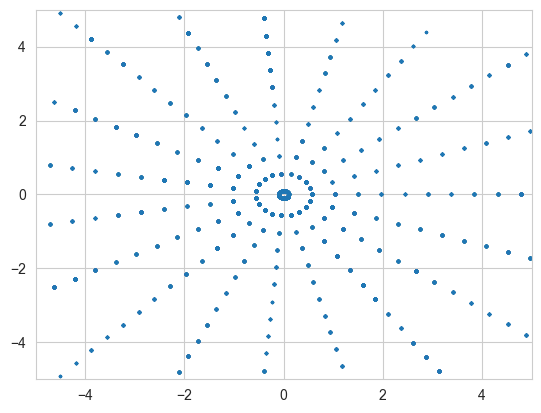

In [70]:
# Amplitude bounds for gauss grid fit - set [min, max]
gauss_grid_bounds = [[prf_settings['prf_ampl'][0],prf_settings['prf_ampl'][1]]]

gauss_fitter.grid_fit(
    ecc_grid=eccs,
    polar_grid=polars,
    size_grid=sizes,
    hrf_1_grid=hrf_1_grid,
    hrf_2_grid=hrf_2_grid,
    verbose=False,
    n_batches=prf_settings['n_batches'],               # The grid fit is performed in parallel over n_batches of units.Batch parallelization is faster than single-unit parallelization and of sequential computing.
    fixed_grid_baseline=prf_settings['fixed_grid_baseline'], # Fix the baseline? This makes sense if we have fixed the baseline in preprocessing
    grid_bounds=gauss_grid_bounds
    )

print(f'Mean rsq = {np.nanmean(gauss_fitter.gridsearch_r2):.3f}')
print(f'Max rsq = {np.nanmax(gauss_fitter.gridsearch_r2):.3f}')
print(np.where(gauss_fitter.gridsearch_r2==np.nanmax(gauss_fitter.gridsearch_r2)))

# Plot the location...
plt.scatter(gauss_fitter.gridsearch_params[:,0], gauss_fitter.gridsearch_params[:,1],marker='o', s=2)
plt.xlim(-5,5)
plt.ylim(-5,5)

## Stage 2: Gaussian Iterative Fit - nohrf
Now we can do the iterative fit. This takes the best fitting grid (from the above stage), and iteratively tweaks the parameters until the best fit is founds.
This takes a bit longer than the grid fit. We also need to setup the bounds for all the parameters.

In [71]:
if prf_settings['constraints']==True:
    g_constraints = [] # uses trust-constraint (which is slower)
else:
    g_constraints = None # uses l-BFGS (which is faster)

gauss_iter_bounds = [
    (-1.5*max_eccentricity, 1.5*max_eccentricity),          # x bound
    (-1.5*max_eccentricity, 1.5*max_eccentricity),          # y bound
    (1e-1, 1.5*max_eccentricity),                             # prf size bounds
    (prf_settings['prf_ampl'][0],prf_settings['prf_ampl'][1]),      # prf amplitude
    (prf_settings['bold_bsl'][0],prf_settings['bold_bsl'][1]),      # bold baseline (fixed)
    (prf_settings['hrf']['deriv_bound'][0], prf_settings['hrf']['deriv_bound'][1]), # hrf_1 bound
    (prf_settings['hrf']['pars'][2], prf_settings['hrf']['pars'][2]), # hrf_2 bound
]

gauss_fitter.iterative_fit(
    rsq_threshold=prf_settings['rsq_threshold'],    # Minimum variance explained. Puts a lower bound on the quality of PRF fits. Any fits worse than this are thrown away...
    verbose=False,
    bounds=gauss_iter_bounds,       # Bounds (on parameters)
    constraints=g_constraints, # Constraints
    xtol=float(prf_settings['xtol']),     # float, passed to fitting routine numerical tolerance on x
    ftol=float(prf_settings['ftol']),     # float, passed to fitting routine numerical tolerance on function
    )

# Rescue vxs where iterative fit was worse than grid fit
rsq_mask=np.ones(gauss_fitter.rsq_mask.shape) #this one is based on grid fit
rsq_mask[gauss_fitter.iterative_search_params[:,7]<prf_settings["rsq_threshold"]]=False
checkrsq=np.where(np.logical_and(gauss_fitter.gridsearch_params[:,-1]>gauss_fitter.iterative_search_params[:,-1],gauss_fitter.iterative_search_params[:,-1]!=0))
gauss_fitter.iterative_search_params[checkrsq,:]=gauss_fitter.gridsearch_params[checkrsq,:]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/Users/mayra/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/mayra/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/mayra/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/mayra/.local/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/ma

Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 768, CG iterations: 382, optimality: 1.66e+01, constraint violation: 0.00e+00, execution time:  8.9 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 237, function evaluations: 1992, CG iterations: 1001, optimality: 5.76e+00, constraint violation: 0.00e+00, execution time: 2.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 118, function evaluations: 976, CG iterations: 484, optimality: 1.49e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 101, function evaluations: 944, CG iterations: 398, optimality: 4.61e-01, constraint violation: 0.

[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 26.1min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 72, function evaluations: 608, CG iterations: 260, optimality: 4.22e+01, constraint violation: 0.00e+00, execution time:  6.5 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 352, CG iterations: 183, optimality: 1.60e+01, constraint violation: 0.00e+00, execution time:  3.7 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 632, CG iterations: 281, optimality: 2.68e+01, constraint violation: 0.00e+00, execution time:  6.7 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 107, function evaluations: 1032, CG iterations: 309, optimality: 6.93e-01, constraint violation: 0.00e+00, ex

[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 42.0min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 147, function evaluations: 1384, CG iterations: 540, optimality: 3.55e-01, constraint violation: 0.00e+00, execution time: 1.5e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 116, function evaluations: 1264, CG iterations: 436, optimality: 1.37e+00, constraint violation: 0.00e+00, execution time: 1.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 158, function evaluations: 1552, CG iterations: 477, optimality: 6.20e-02, constraint violation: 0.00e+00, execution time: 1.7e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 110, function evaluations: 1160, CG iterations: 340, optimality: 5.47e-02, constraint violatio

[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 61.0min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 928, CG iterations: 275, optimality: 1.57e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 126, function evaluations: 1208, CG iterations: 516, optimality: 2.62e+00, constraint violation: 0.00e+00, execution time: 1.3e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 124, function evaluations: 1080, CG iterations: 403, optimality: 3.97e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 992, CG iterations: 479, optimality: 1.84e+00, constraint violation: 0.

[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 81.6min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 125, function evaluations: 1368, CG iterations: 472, optimality: 1.45e-01, constraint violation: 0.00e+00, execution time: 1.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 102, function evaluations: 968, CG iterations: 314, optimality: 2.75e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 688, CG iterations: 191, optimality: 1.34e+00, constraint violation: 0.00e+00, execution time:  7.0 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 151, function evaluations: 1384, CG iterations: 522, optimality: 1.04e+00, constraint violation: 0.00e

[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 107.0min


Number of iterations: 134, function evaluations: 1368, CG iterations: 370, optimality: 4.41e-01, constraint violation: 0.00e+00, execution time: 1.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 1176, CG iterations: 377, optimality: 3.74e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 125, function evaluations: 1368, CG iterations: 442, optimality: 2.43e-01, constraint violation: 0.00e+00, execution time: 1.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 688, CG iterations: 230, optimality: 7.36e+00, constraint violation: 0.00e+00, execution time:  7.0 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` t

[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 135.9min


Number of iterations: 159, function evaluations: 1552, CG iterations: 509, optimality: 3.37e+00, constraint violation: 0.00e+00, execution time: 1.6e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 784, CG iterations: 338, optimality: 6.51e-01, constraint violation: 0.00e+00, execution time:  8.2 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 112, function evaluations: 1120, CG iterations: 435, optimality: 3.61e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 74, function evaluations: 728, CG iterations: 273, optimality: 3.33e+01, constraint violation: 0.00e+00, execution time:  7.6 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termin

[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 166.9min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 88, function evaluations: 832, CG iterations: 233, optimality: 1.41e-01, constraint violation: 0.00e+00, execution time:  9.3 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 108, function evaluations: 1096, CG iterations: 327, optimality: 7.20e-01, constraint violation: 0.00e+00, execution time: 1.3e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 1112, CG iterations: 419, optimality: 5.66e+01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 80, function evaluations: 888, CG iterations: 246, optimality: 1.23e+00, constraint violation: 0.00

[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 201.1min


`xtol` termination condition is satisfied.
Number of iterations: 184, function evaluations: 1824, CG iterations: 698, optimality: 1.96e-01, constraint violation: 0.00e+00, execution time: 1.9e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 132, function evaluations: 1472, CG iterations: 416, optimality: 1.97e+00, constraint violation: 0.00e+00, execution time: 1.5e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 109, function evaluations: 1160, CG iterations: 430, optimality: 7.57e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 984, CG iterations: 322, optimality: 1.41e+01, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, cons

[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 239.8min


Number of iterations: 89, function evaluations: 872, CG iterations: 316, optimality: 2.74e-01, constraint violation: 0.00e+00, execution time:  8.8 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 648, CG iterations: 151, optimality: 1.03e+00, constraint violation: 0.00e+00, execution time:  6.5 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 83, function evaluations: 904, CG iterations: 246, optimality: 9.75e-02, constraint violation: 0.00e+00, execution time:  9.2 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 1136, CG iterations: 403, optimality: 4.29e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination

[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 280.4min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 178, function evaluations: 1872, CG iterations: 622, optimality: 5.86e-01, constraint violation: 0.00e+00, execution time: 1.9e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 624, CG iterations: 232, optimality: 1.07e+00, constraint violation: 0.00e+00, execution time:  6.3 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 118, function evaluations: 1184, CG iterations: 357, optimality: 1.12e+00, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 1088, CG iterations: 312, optimality: 1.83e+00, constraint violation: 0.

[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 325.3min


`xtol` termination condition is satisfied.
Number of iterations: 114, function evaluations: 1176, CG iterations: 330, optimality: 1.24e+01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 992, CG iterations: 298, optimality: 1.82e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 151, function evaluations: 1456, CG iterations: 571, optimality: 4.18e-01, constraint violation: 0.00e+00, execution time: 1.5e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 328, CG iterations: 157, optimality: 6.53e-01, constraint violation: 0.00e+00, execution time:  3.2 s.
Performing bounded, constraine

[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 371.9min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 1200, CG iterations: 548, optimality: 2.94e+00, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 960, CG iterations: 308, optimality: 2.29e+00, constraint violation: 0.00e+00, execution time:  9.8 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 1080, CG iterations: 329, optimality: 9.03e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 768, CG iterations: 345, optimality: 1.32e+00, constraint violation: 0.00

[Parallel(n_jobs=6)]: Done 12788 tasks      | elapsed: 422.1min


Number of iterations: 62, function evaluations: 664, CG iterations: 163, optimality: 6.59e-01, constraint violation: 0.00e+00, execution time:  6.6 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 247, function evaluations: 2296, CG iterations: 1047, optimality: 3.98e-01, constraint violation: 0.00e+00, execution time: 2.3e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 170, function evaluations: 1768, CG iterations: 614, optimality: 3.07e-01, constraint violation: 0.00e+00, execution time: 1.8e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 832, CG iterations: 277, optimality: 1.68e-01, constraint violation: 0.00e+00, execution time:  8.4 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termi

[Parallel(n_jobs=6)]: Done 14438 tasks      | elapsed: 478.0min


Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 88, function evaluations: 816, CG iterations: 333, optimality: 5.68e+00, constraint violation: 0.00e+00, execution time:  8.2 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 1144, CG iterations: 475, optimality: 3.70e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 104, function evaluations: 992, CG iterations: 326, optimality: 2.73e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 728, CG iterations: 229, optimality: 3.90e-01, constraint violation: 0.00e+0

[Parallel(n_jobs=6)]: Done 16188 tasks      | elapsed: 538.9min


Number of iterations: 105, function evaluations: 1040, CG iterations: 411, optimality: 1.90e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 153, function evaluations: 1400, CG iterations: 631, optimality: 6.95e-01, constraint violation: 0.00e+00, execution time: 1.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 126, function evaluations: 1088, CG iterations: 471, optimality: 3.24e+00, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 1016, CG iterations: 324, optimality: 5.40e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol`

[Parallel(n_jobs=6)]: Done 18038 tasks      | elapsed: 600.1min


Number of iterations: 357, function evaluations: 3336, CG iterations: 1310, optimality: 3.98e-01, constraint violation: 0.00e+00, execution time: 3.4e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 112, function evaluations: 984, CG iterations: 431, optimality: 3.31e-01, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 968, CG iterations: 315, optimality: 1.20e+00, constraint violation: 0.00e+00, execution time:  9.8 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 126, function evaluations: 1312, CG iterations: 497, optimality: 2.42e+00, constraint violation: 0.00e+00, execution time: 1.3e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` ter

[Parallel(n_jobs=6)]: Done 19988 tasks      | elapsed: 665.2min


Number of iterations: 63, function evaluations: 448, CG iterations: 248, optimality: 1.35e-02, constraint violation: 0.00e+00, execution time:  4.5 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 98, function evaluations: 920, CG iterations: 299, optimality: 2.17e-01, constraint violation: 0.00e+00, execution time:  9.2 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 368, CG iterations: 160, optimality: 1.36e+00, constraint violation: 0.00e+00, execution time:  3.7 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 108, function evaluations: 1032, CG iterations: 345, optimality: 1.22e+00, constraint violation: 0.00e+00, execution time: 1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination c

[Parallel(n_jobs=6)]: Done 22038 tasks      | elapsed: 734.7min


Number of iterations: 89, function evaluations: 928, CG iterations: 273, optimality: 5.93e-01, constraint violation: 0.00e+00, execution time:  9.6 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 127, function evaluations: 928, CG iterations: 505, optimality: 1.82e+01, constraint violation: 0.00e+00, execution time:  9.6 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 116, function evaluations: 1040, CG iterations: 390, optimality: 2.42e-01, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 154, function evaluations: 1328, CG iterations: 539, optimality: 2.86e+00, constraint violation: 0.00e+00, execution time: 1.3e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termi

[Parallel(n_jobs=6)]: Done 22835 out of 22835 | elapsed: 761.1min finished


Min rsq = 0.011
Mean rsq = 0.236
Max rsq = 0.761
(array([14569]),)


(-5.0, 5.0)

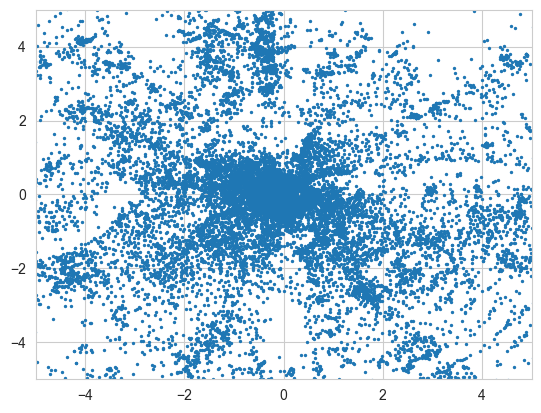

In [72]:
print(f'Min rsq = {np.nanmin(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,-1]):.3f}')
print(f'Mean rsq = {np.nanmean(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask>0,-1]):.3f}')
print(f'Max rsq = {gauss_fitter.iterative_search_params[:,-1].max():.3f}')
print(np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max()))

# Plot the location...
plt.scatter(gauss_fitter.iterative_search_params[:,0], gauss_fitter.iterative_search_params[:,1],marker='o', s=2)
plt.xlim(-5,5)
plt.ylim(-5,5)

In [73]:
best_vx=np.where(gauss_fitter.iterative_search_params[:,-1]==gauss_fitter.iterative_search_params[:,-1].max())
best_vx

(array([14569]),)

# WELL DONE!
We now have a set of prf fits. 


In [74]:
# We can now create the predicted timeseries, and compare these with the data

prf_params = gauss_fitter.iterative_search_params
pred_tc=gauss_model.return_prediction(
    mu_x = prf_params[:,0], # x position
    mu_y = prf_params[:,1], # y position
    size = prf_params[:,2], # prf size
    beta = prf_params[:,3], # prf amplitude
    baseline = prf_params[:,4], # prf baseline (set to 0)
    hrf_1 = prf_params[:,5],
    hrf_2 = prf_params[:,6],
)

/Users/mayra/PycharmProjects/Github/prfpy/prfpy/rf.py:112: RuntimeWarning: divide by zero encountered in divide
  return (np.exp(-((x-mu[0])**2 + (y-mu[1])**2)/(2*sigma**2))).astype('float32')


Have a look at the model fits:
* vary the voxel you are looking at (i_vx)
* also look at how the parameters (in the title), determine the location and size of the RF
* varying "time_pt", you can see where the stimulus is, at different times
* Note that the HRF means that responses of the model will be delayed...

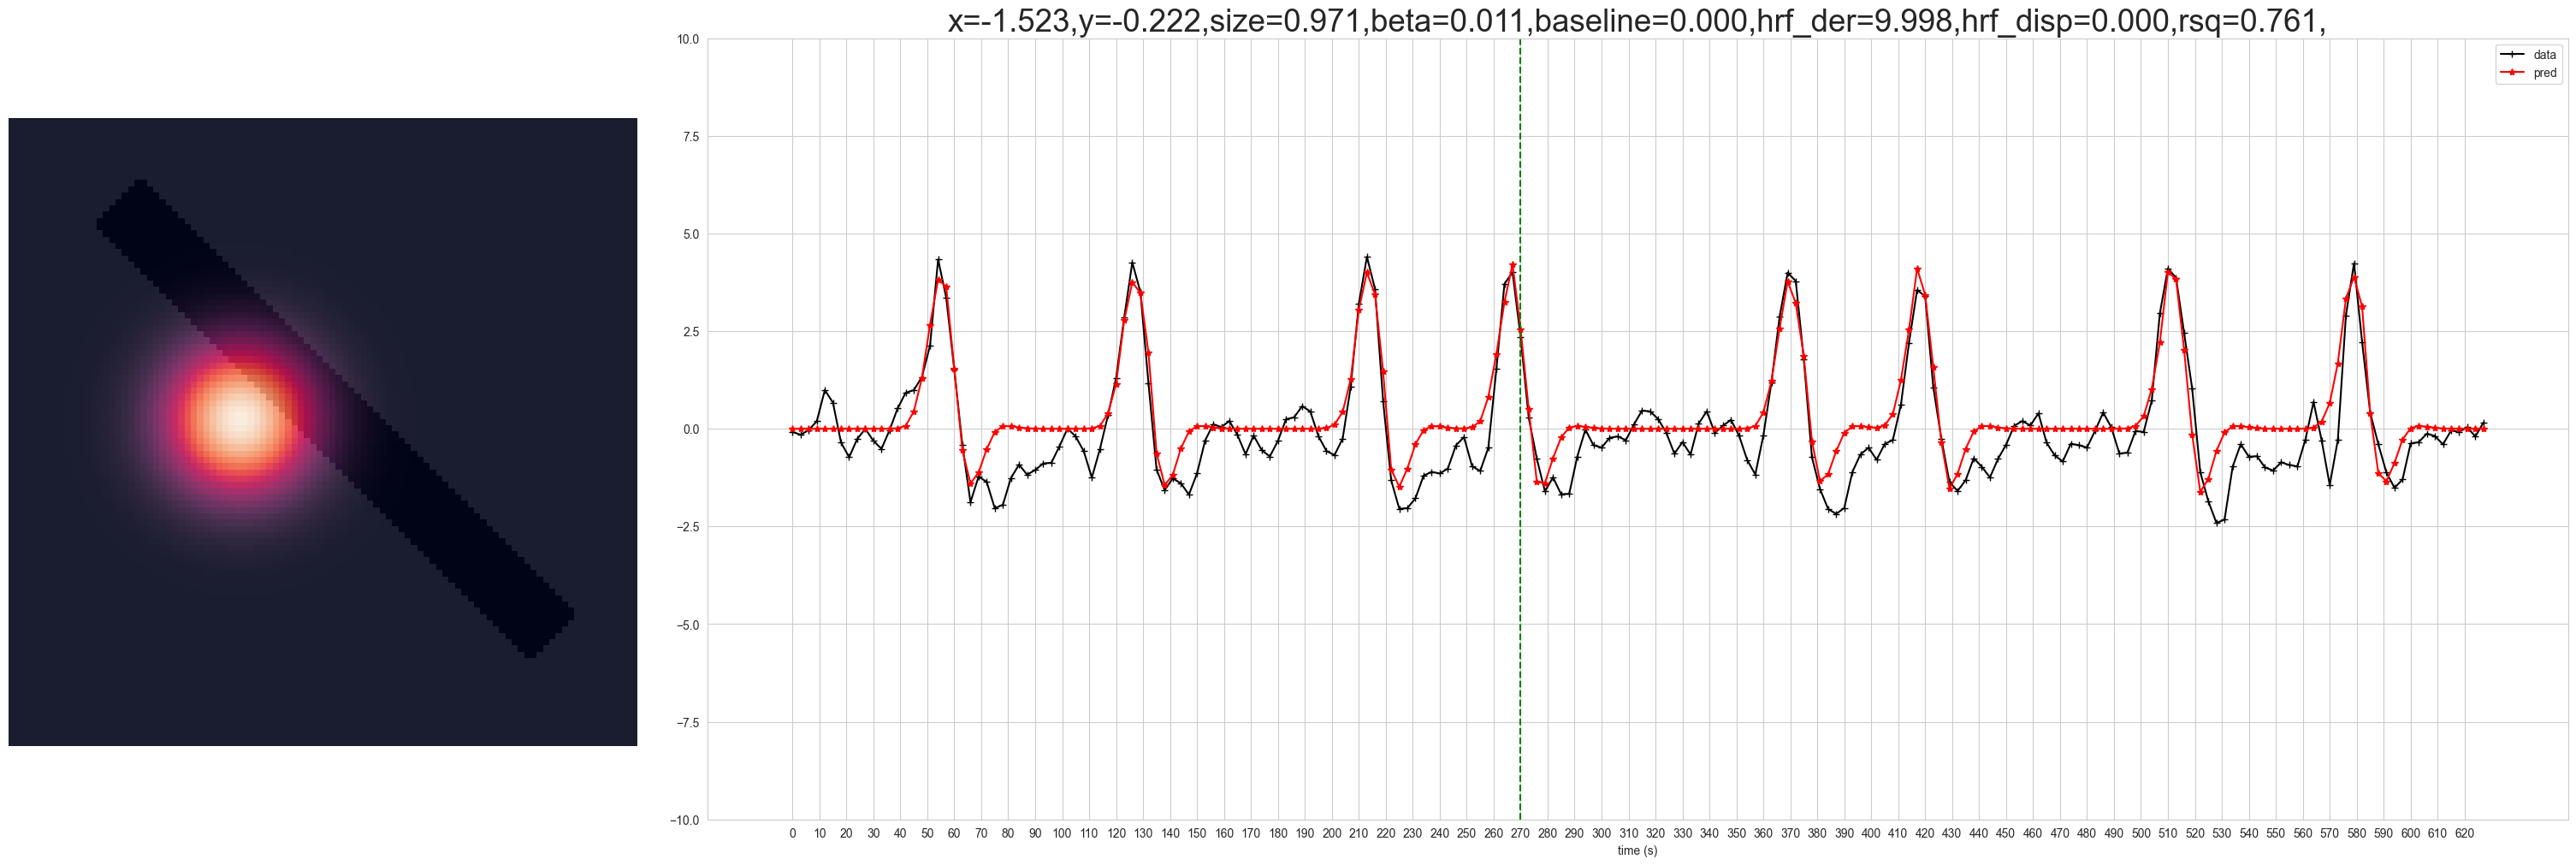

In [75]:
TR_s = prf_settings['TR']
fig = plt.figure(constrained_layout=True, figsize=(30,10))
subfigs = fig.subfigures(1, 2, width_ratios=[10,30])
i_vx = int(best_vx[0])
#i_vx=24798

# ************* TIME COURSE PLOT *************
time_pts = np.arange(psc_avg_ts.shape[1]) * TR_s    
ax2 = subfigs[1].add_subplot()
ax2.plot(time_pts, psc_avg_ts[i_vx,:], '-+k', label= 'data')
ax2.plot(time_pts, pred_tc[i_vx,:], '-*r', label= 'pred')
# ax2.plot(time_pts, pred_tc_nohrf[i_vx,:], '-*b', label= 'pred_nohrf')
ax2.set_xlabel('time (s)')
ax2.legend()
ax2.set_ylim([-10,10])
plt.rcParams.update({'font.size': 22})


gauss_param_name = ['x', 'y', 'size', 'beta', 'baseline', 'hrf_der','hrf_disp','rsq']
title_txt = ''
for i,p in enumerate(gauss_param_name):
    title_txt += f'{p}={prf_params[i_vx,i]:.3f},'
ax2.set_title(title_txt)

# ********* PRF PLOT **********
rf = gauss2D_iso_cart(
    x=prf_stim.x_coordinates,
    y=prf_stim.y_coordinates,
    mu=(prf_params[i_vx,0], prf_params[i_vx,1]),
    sigma=prf_params[i_vx,2])
ax1 = subfigs[0].add_subplot()
ax1.imshow(rf, vmin=0, vmax=1, extent=[-5,5,-5,5])
ax1.axis('off')

time_pt = 90
if time_pt != None:
    ax1.imshow(dm[:,:,time_pt], vmin=0, vmax=1,cmap='Greys', alpha=0.1, extent=[-5,5,-5,5])
    ax_lim = ax2.get_ylim()
    ax2.plot((time_pt*TR_s, time_pt*TR_s), (ax_lim), '--g')

ax2.set_xticks(np.arange(time_pts[0], time_pts[-1],10))
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)
add_dm_to_ts(fig, ax2, dm, TR=TR_s, dx_axs=2)

Mean r2= 0.236
Min r2= 0.011
Max r2= 0.761


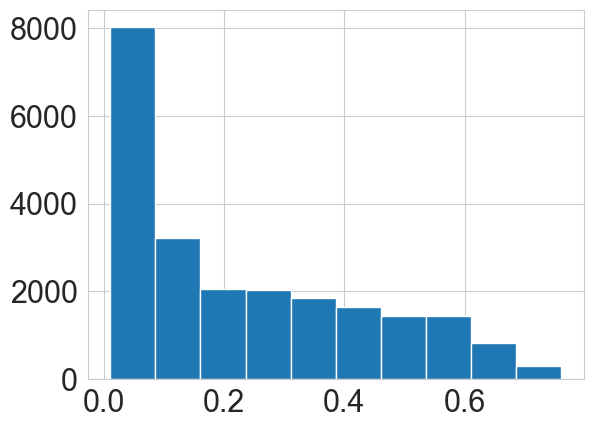

Best vx hrf_deriv= 9.998
Best vx size= 0.971
Best vx r2 no_hrf_grid= 0.757
Best vx r2 no_hrf_iter= 0.761
Best vx r2 iter= 0.761
Nvx = 22835 out of 22862, 99.9%


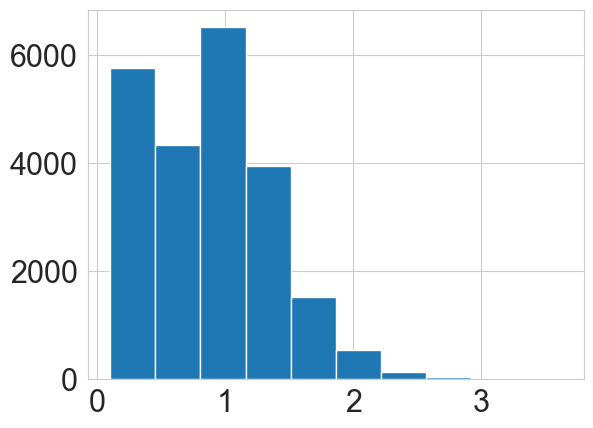

In [76]:
print(f'Mean r2= {np.nanmean(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7]):.3f}')
print(f'Min r2= {np.min(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask==1,7]):.3f}')
print(f'Max r2= {np.max(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7]):.3f}')
plt.hist(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,7])
plt.show()
plt.hist(gauss_fitter.iterative_search_params[gauss_fitter.rsq_mask!=0,2])
print(f'Best vx hrf_deriv= {gauss_fitter.iterative_search_params[int(best_vx[0]),-3]:.3f}')
print(f'Best vx size= {gauss_fitter.iterative_search_params[int(best_vx[0]),2]:.3f}')
print(f'Best vx r2 no_hrf_grid= {gauss_fitter.gridsearch_params[int(best_vx[0]),-1]:.3f}')
print(f'Best vx r2 no_hrf_iter= {gauss_fitter.iterative_search_params[int(best_vx[0]),-1]:.3f}')
print(f'Best vx r2 iter= {gauss_fitter.iterative_search_params[int(best_vx[0]),-1]:.3f}')

print(f'Nvx = {np.count_nonzero(gauss_fitter.rsq_mask)} out of {rsq_mask.shape[0]}, {np.count_nonzero(gauss_fitter.rsq_mask)/rsq_mask.shape[0]*100:.1f}%')

In [77]:
import pickle
def save_params(model, model_name):

    if rois.__len__()==1:
        pkl_file = opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'roi-{rois[0]}_model-{atlas}-{model_name}-{depth}_desc-prf_params.pkl')
    else:
        pkl_file = opj(f'{MAIN_PATH}/pRFM/{subject}/ses-1/{denoising}/', f'model-{atlas}-{model_name}-{depth}_desc-prf_params.pkl')

    # get parameters given model and stage
    model=model
    settings = prf_settings
    prf_params = model.iterative_search_params
    pred_tc = gauss_model.return_prediction(
    mu_x = prf_params[:,0], # x position
    mu_y = prf_params[:,1], # y position
    size = prf_params[:,2], # prf size
    beta = prf_params[:,3], # prf amplitude
    baseline = prf_params[:,4], # prf baseline (set to 0)
    hrf_1 = prf_params[:,5],
    hrf_2 = prf_params[:,6],
    )

    # write a pickle-file with relevant outputs
    out_dict = {}
    out_dict['model'] = model
    out_dict['settings'] = settings
    out_dict['pred_tc'] = pred_tc
    out_dict['rois_mask'] = rois_mask.data
    if rois.__len__()==1:
        out_dict['roi_verts'] = roi_verts

    f = open(pkl_file, "wb")
    pickle.dump(out_dict, f)
    f.close()

In [78]:
save_params(gauss_fitter, 'gauss_fitter')